In [1]:
from sympy import init_printing
init_printing()

# The 'Andoyer' model for Resonance
The 'Andoyer' class of Hamiltonians provide models for $k$th-order mean motion resonance (e.g. Ferraz-Mello 2007). After a long slog of canoncial tranformations, one can show that the resonant dynamics of a pair of planets is governed by a Hamiltonian of the form:
\begin{equation}
H_{k}(\Phi,\phi;\alpha) = 4\Phi^2-3\alpha\Phi +(\sqrt{2\Phi})^{k/2}\cos\phi 
\end{equation}
where 
\begin{eqnarray}
\Phi&\propto& \Delta a /a_\text{res.} \\
\phi&=&j\lambda_{out} - (j-k)\lambda_{in} - k\varpi\\
\alpha &\propto& <e^2>
\end{eqnarray}.
 These models offer the simplicity of a one-parameter Hamiltonian with a single degree of freedom. However, translating these models to and from orbital elements can be tedious. Luckily, celmech can do it for you!

In [2]:
from celmech import Andoyer, AndoyerHamiltonian

The code below sets up an interactive interface for integrating 'Andoyer' models

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

class Clicker(object):
    def __init__(self,j,k, Phiprime, projection=None):
        self.ax = plt.subplot('111', projection=projection)
        self.j = j
        self.k = k
        self.Phiprime = Phiprime
        self.projection = projection
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        phi = event.xdata
        Phi = event.ydata
        if Phi < 0:
            return
        andvars = Andoyer(self.j,self.k,Phi,phi,Phiprime=self.Phiprime,G=4*np.pi*np.pi) # could choose any j
        self.andvars = andvars
        H = AndoyerHamiltonian(andvars)
        tmax=100
        Nout = 1000
        times = np.linspace(0, tmax, Nout)
        Phi, phi = np.zeros(Nout), np.zeros(Nout)
        for i, time in enumerate(times):
            H.integrate(time)
            Phi[i] = H.state.Phi
            phi[i] = H.state.phi
        if self.projection is None:
            self.ax.plot(npwrap(phi), Phi, 'r.')
            
        else:
            self.ax.plot(phi, Phi, 'r.')
            ax.set_rlim(0,2*self.Phiprime)

# Click to simulate a simple resonance model

<IPython.core.display.Javascript object>


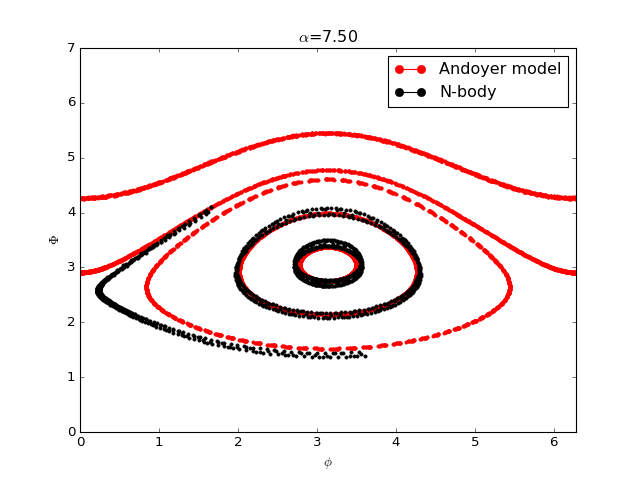

In [4]:
resonance,res_order = 5,2
alpha = 7.5
clicker=Clicker(5,2,alpha) 
import matplotlib.lines as mlines
red_line = mlines.Line2D([], [], color='red', marker='.',
                          markersize=15, label='Andoyer model')
black_line = mlines.Line2D([], [], color='black', marker='.',
                          markersize=15, label='N-body')
plt.legend(handles=[red_line,black_line])

plt.show()

clicker.ax.set_xlim(0,2*np.pi)
clicker.ax.set_ylim(0,7)
clicker.ax.set_xlabel('$\phi$')
clicker.ax.set_ylabel('$\Phi$')
clicker.ax.set_title("$\\alpha$=%.2f"%(alpha))

# Use canonical transformations to generate N-body integrations!


Initialize N-body integrations directly from  ($\Phi,\phi$) phase space

Run integrations and transform them back

Works for 1st, 2nd and 3rd order resonances.

Applies for general 2-planet system (i.e., no restriction to circular/test-particle case!)

## Run an N-body integration initialzed from the last trajectory clicked

<IPython.core.display.Javascript object>


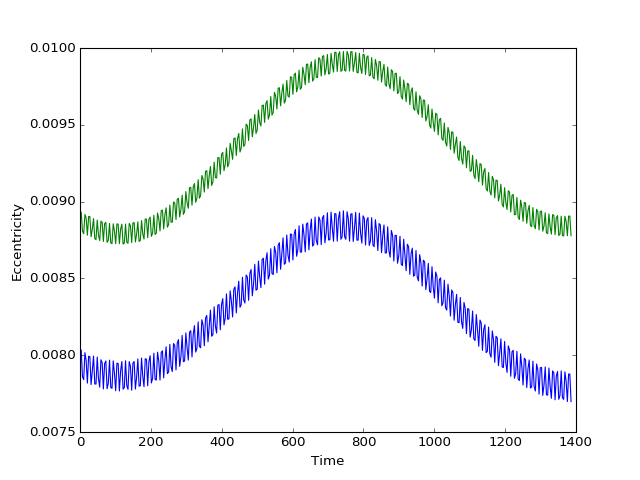

In [8]:
j,k,a10=clicker.andvars.params['j'],clicker.andvars.params['k'],clicker.andvars.params['a10']
sim=clicker.andvars.to_Simulation();
tFin,Nout = 1 * abs(clicker.andvars.params['tau']) , 400
times = np.linspace(0,tFin,Nout)
NPhi,Nphi=np.zeros((2,Nout))
orbits=np.zeros((2,4,Nout))
for i,t in enumerate(times):
    NPhi[i] = Andoyer.from_Simulation(sim,j,k,a10).Phi
    Nphi[i] = Andoyer.from_Simulation(sim,j,k,a10).phi
    orbs=sim.calculate_orbits()
    orbits[0,:,i] = orbs[0].a,orbs[0].e,orbs[0].l,orbs[0].pomega
    orbits[1,:,i] = orbs[1].a,orbs[1].e,orbs[1].l,orbs[1].pomega
    sim.integrate(t)

clicker.ax.plot(npwrap(Nphi),NPhi,'k.')
fig,ax = plt.subplots(1)
ax.plot(times,orbits[0,1],label='Planet 1')
ax.plot(times,orbits[1,1],label='Planet 2')
ax.set_xlabel('Time')
ax.set_ylabel('Eccentricity')